In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

from scipy.signal import find_peaks

from neurodsp import sim
from neurodsp import filt
from neurodsp import spectral

from bycycle.features import compute_features
from bycycle.cyclepoints import find_extrema, find_zerox
from bycycle.cyclepoints.zerox import find_flank_zerox
from bycycle.plts import plot_cyclepoints_array, plot_burst_detect_summary

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,6)})
sns.set_style('whitegrid')
sns.set_style("whitegrid", {'axes.grid' : False})


## Simulate a tonic oscillation

The following cell simulates a sawtooth rhythm at 11 Hz, embedded in 1/f noise. 

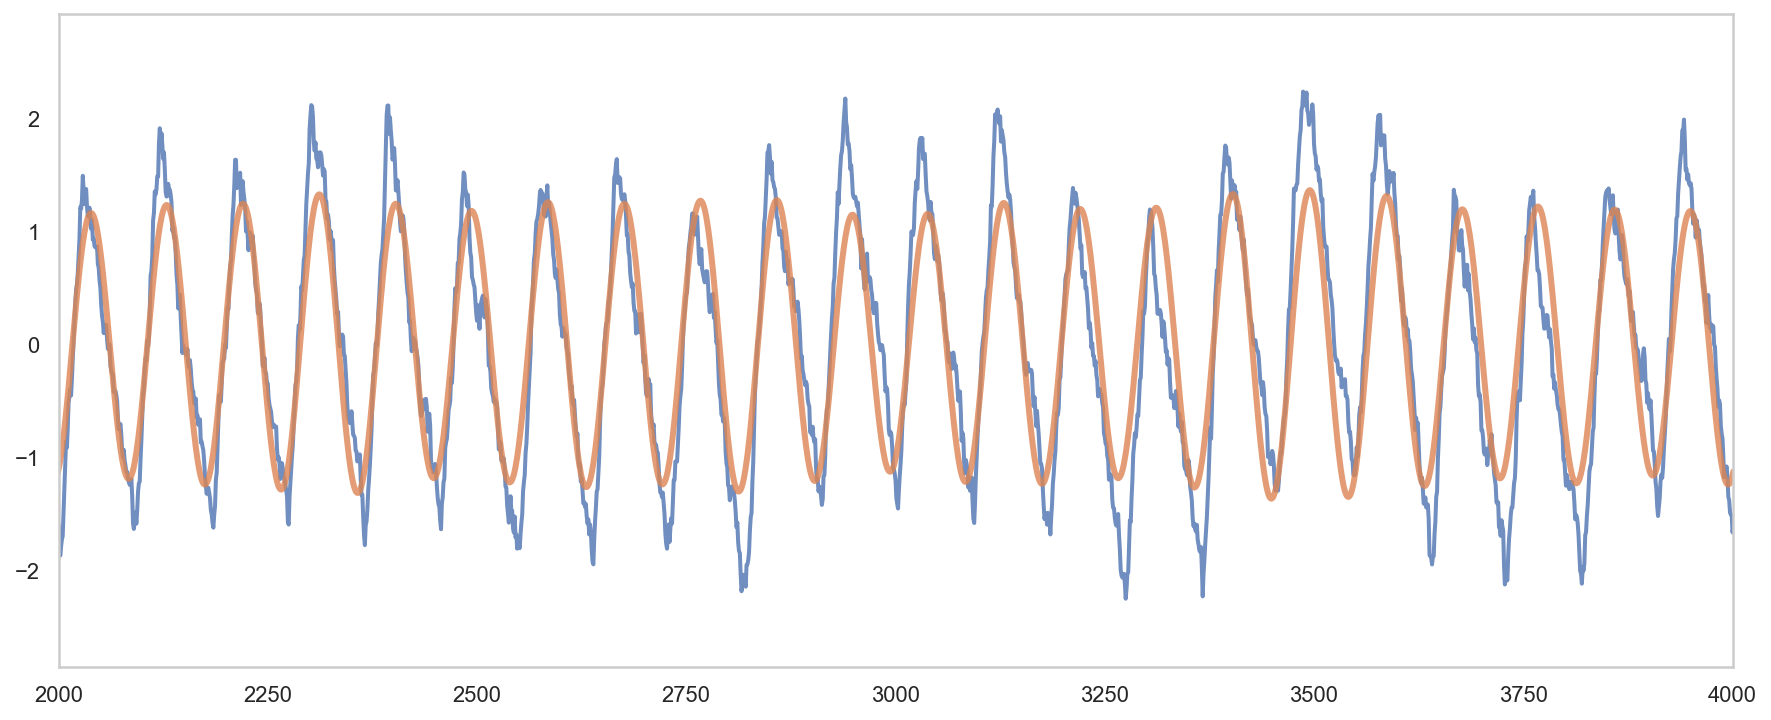

In [2]:
nsec = 20. # how many seconds to simuate
fs = 1000 # sampling rate
osc_freq = 11 # frequency of oscillation to simulate
exp = -1.6 # exponent for the 1/f noise to add to the data
fc = (8,12) # define the narrow frequency band of interest to filter over

# simulate an aperiodic component, and add an oscillation
data = sim.aperiodic.sim_powerlaw(nsec, fs, exponent=exp)
data = data + sim.sim_oscillation(nsec, fs, freq=osc_freq, cycle='sawtooth', width=0.3) 

# highpass filter to remove slow drifts
data = filt.filter_signal(data, fs, 'highpass', 1.)

# Filter the data
alpha_data = filt.filter_signal(data, fs, 'bandpass', f_range=fc, remove_edges=False)

# plot a few seconds of the data
plt.plot(data, alpha=0.8, linewidth = 2.)
plt.plot(alpha_data, alpha=0.8, linewidth = 3.)
plt.xlim(2000, 4000)
plt.show()


## Isolating individual cycle peaks and troughs

This (very crude!) code find the voltage peaks and troughs in the data, and also the peaks and troughs in the narrowband filtered signal of the data.

You'll see that the voltage peaks tend to preced the peaks in the filtered signal, while the voltage troughs tend to occur after the toughs in the filtered signal.

This is to demonstrate how a filter can bias your understanding of the data.

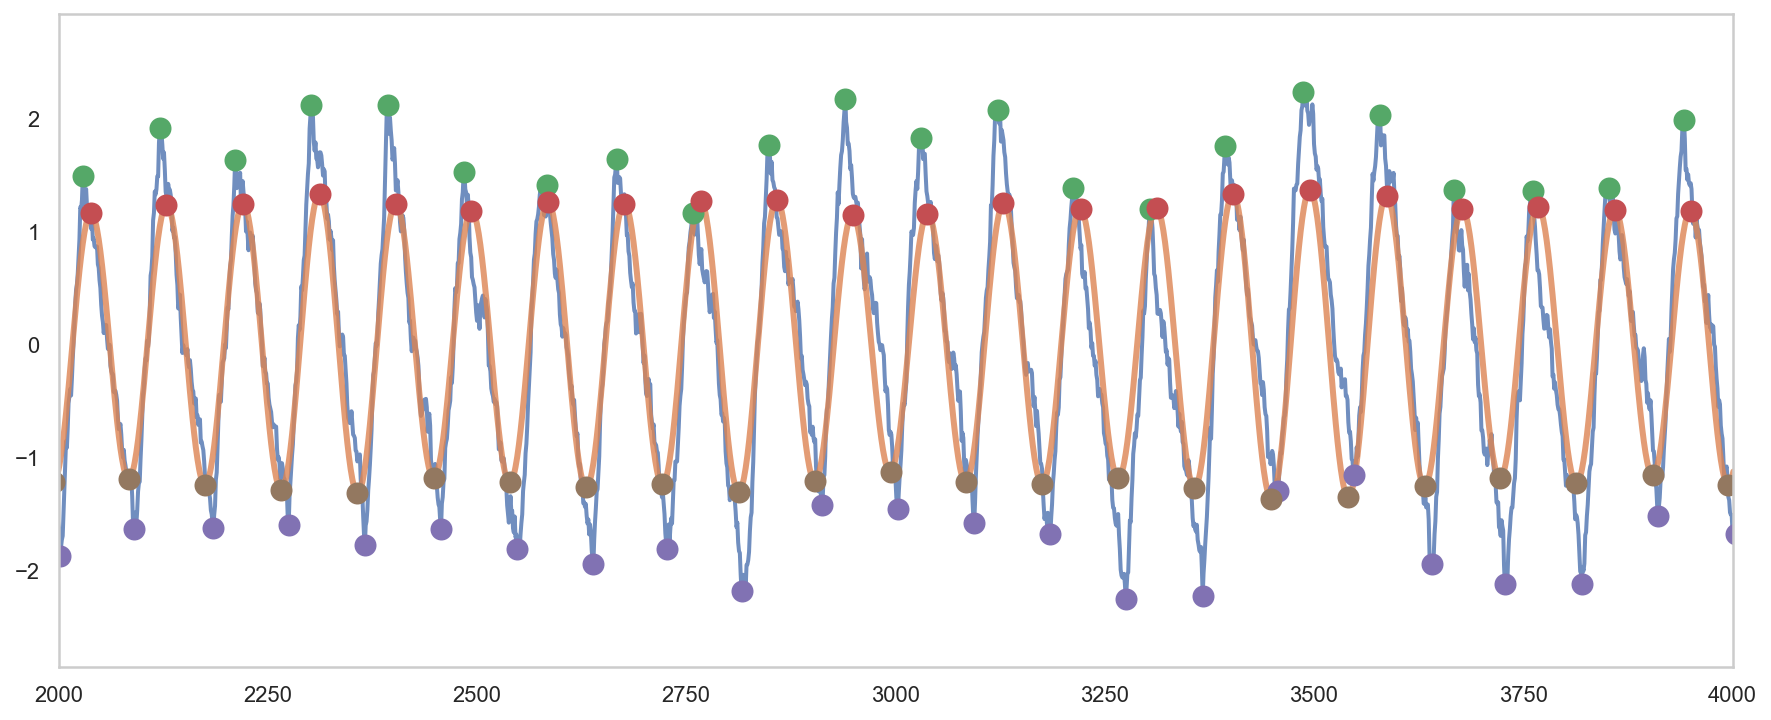

In [3]:
separation = 70

# find the peaks
peaks, _ = find_peaks(data, distance=separation)
apeaks, _ = find_peaks(alpha_data, distance=separation)

# find the troughs
troughs, _ = find_peaks(-data, distance=separation)
atroughs, _ = find_peaks(-alpha_data, distance=separation)

# plot it all
plt.plot(data, alpha=0.8, linewidth = 2.)
plt.plot(alpha_data, alpha=0.8, linewidth = 3.)
plt.plot(peaks, data[peaks], 'o', markersize = 10.)
plt.plot(apeaks, alpha_data[apeaks], 'o', markersize = 10.)
plt.plot(troughs, data[troughs], 'o', markersize = 10.)
plt.plot(atroughs, alpha_data[atroughs], 'o', markersize = 10.)
plt.xlim(2000, 4000)
plt.show()

## Power spectra for nonsinusoidal oscillations

For many nonsinusoidal rhythms, the nonsinusoidalities are captured by power at harmonics of the fundamental frequency.

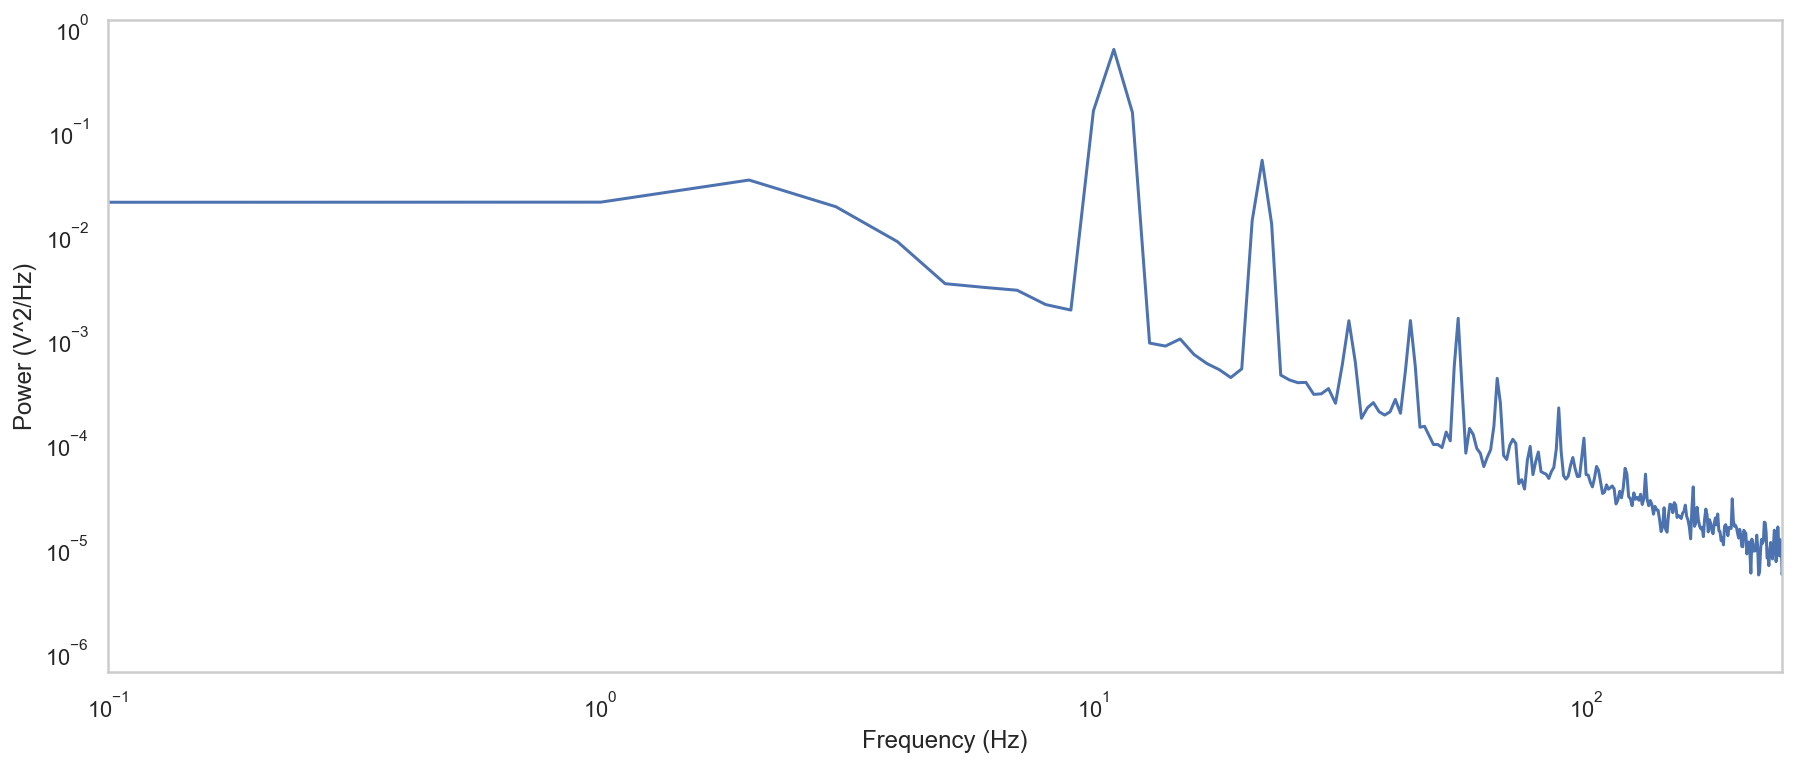

In [4]:
data = data[np.logical_not(np.isnan(data))] # remove an nans

# get the spectrum
freq_mean, P_mean = spectral.compute_spectrum(data, fs, method='welch',
                                              window='hann', nperseg=fs) # mean of spectrogram (Welch)

# plot it
plt.loglog(freq_mean, P_mean)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V^2/Hz)')
plt.xlim((0.1, 250))
plt.show()


## Bycycle analysis of bursty oscillations

Next, we'll instead simulate a bursty (non-stationary) nonsinusoidal oscillation.

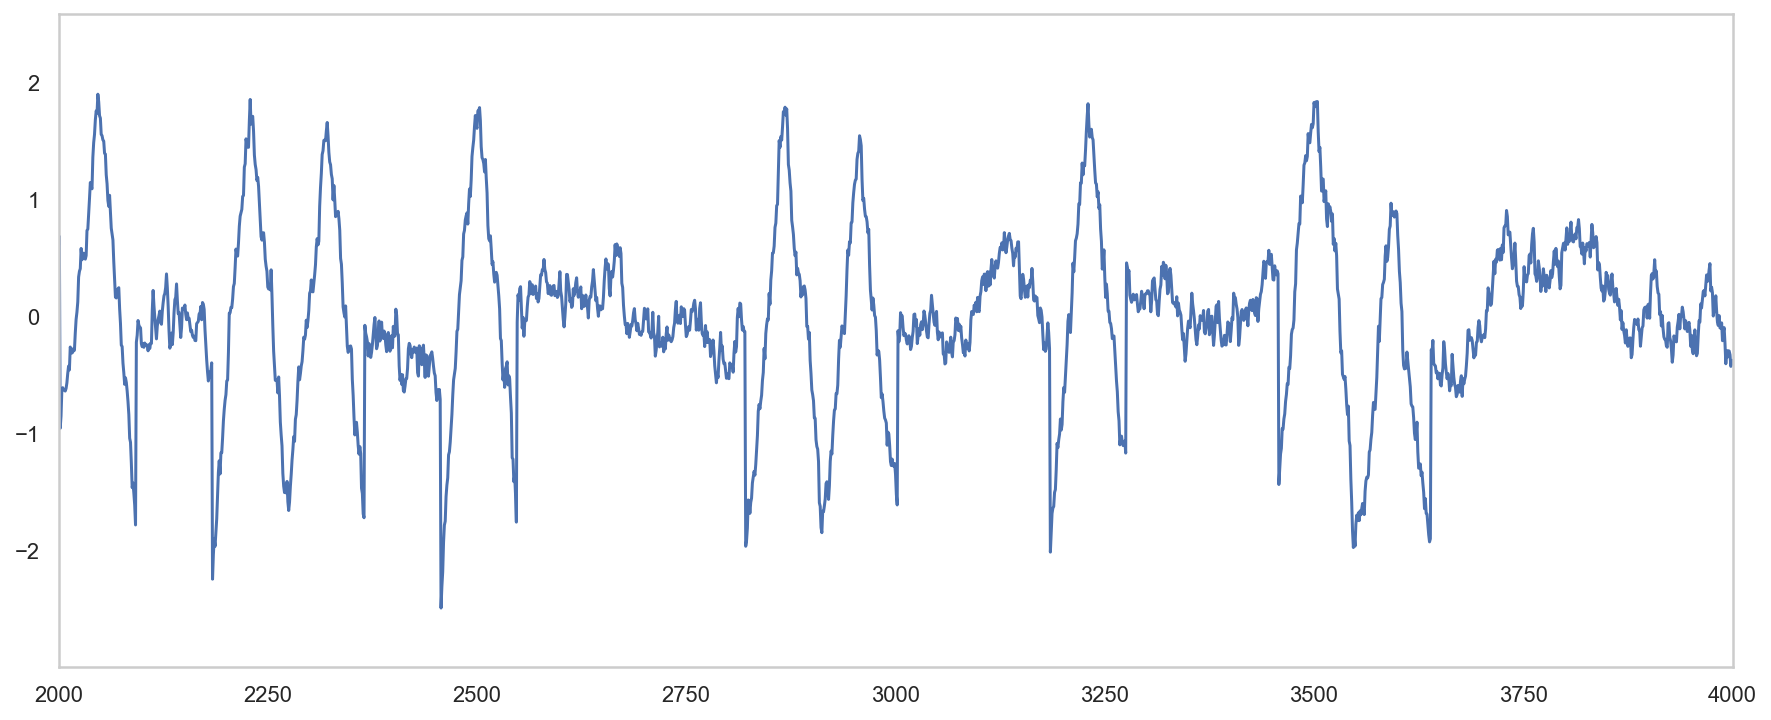

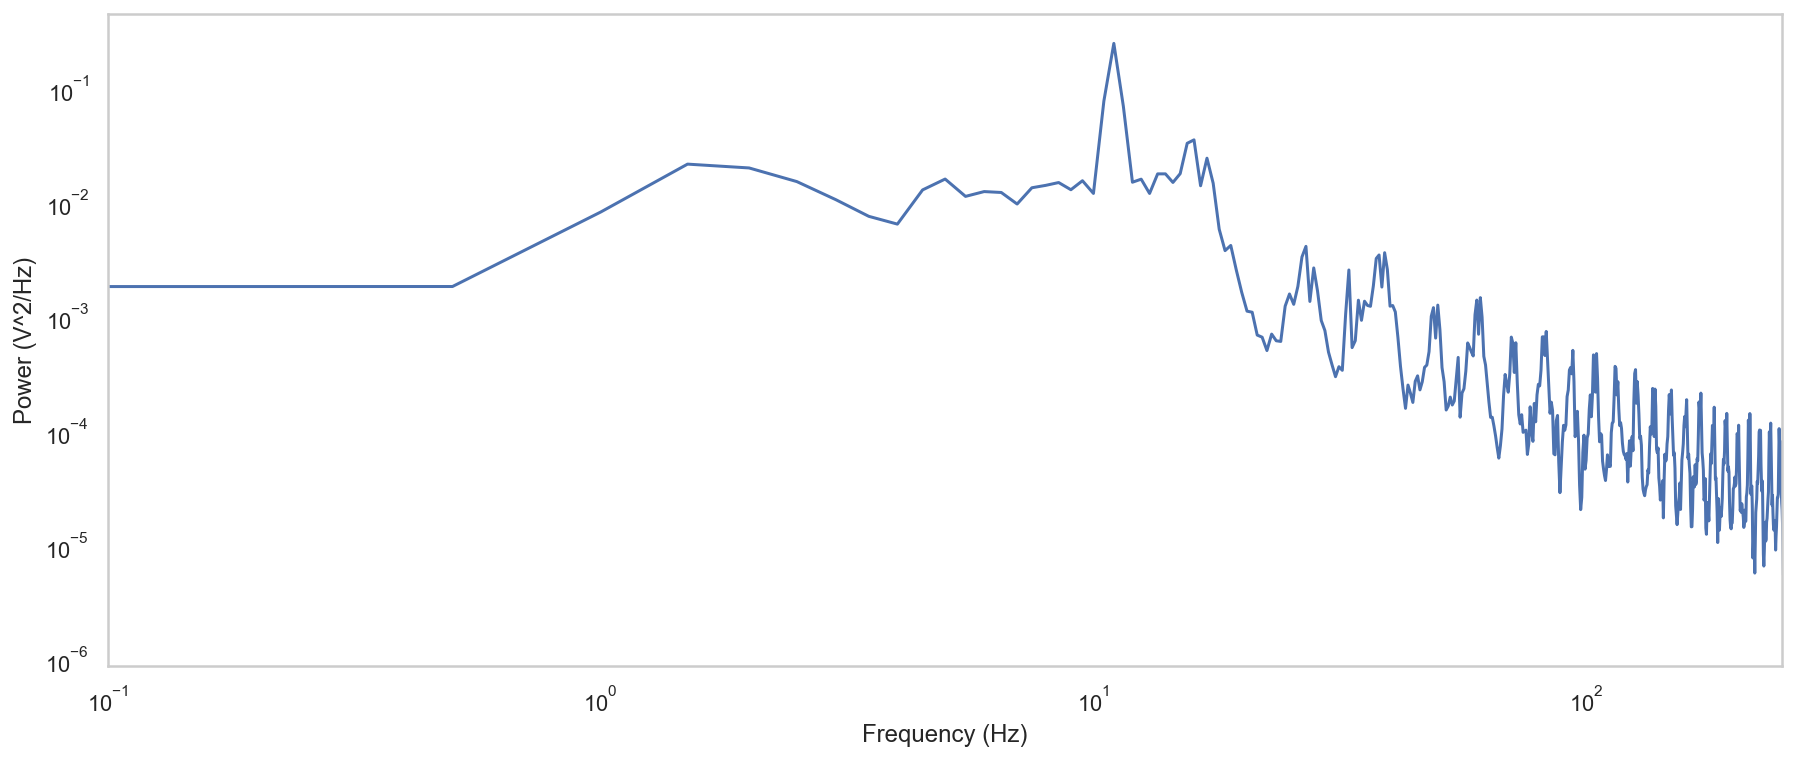

In [5]:
# simulate an aperiodic component, and add a bursty oscillation
bursty_data = sim.aperiodic.sim_powerlaw(nsec, fs, exponent=exp)
bursty_data = bursty_data + sim.sim_bursty_oscillation(nsec, fs, freq=osc_freq,
        enter_burst=0.5, leave_burst=0.7, cycle='sawtooth', width=0.5)

# light highpass filter
bursty_data = filt.filter_signal(bursty_data, fs, 'highpass', 1., remove_edges=False)

# power spectrum
F_burst, P_burst = spectral.compute_spectrum(bursty_data, fs, method='welch',
                                               window='hann', nperseg=fs*2)

# plot it
plt.plot(bursty_data)
plt.xlim(2000, 4000)
plt.show()

plt.loglog(F_burst, P_burst)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V^2/Hz)')
plt.xlim((0.1, 250))
plt.show()

#### Using bycycle, we can identify the peaks and troughs of the data and plot them

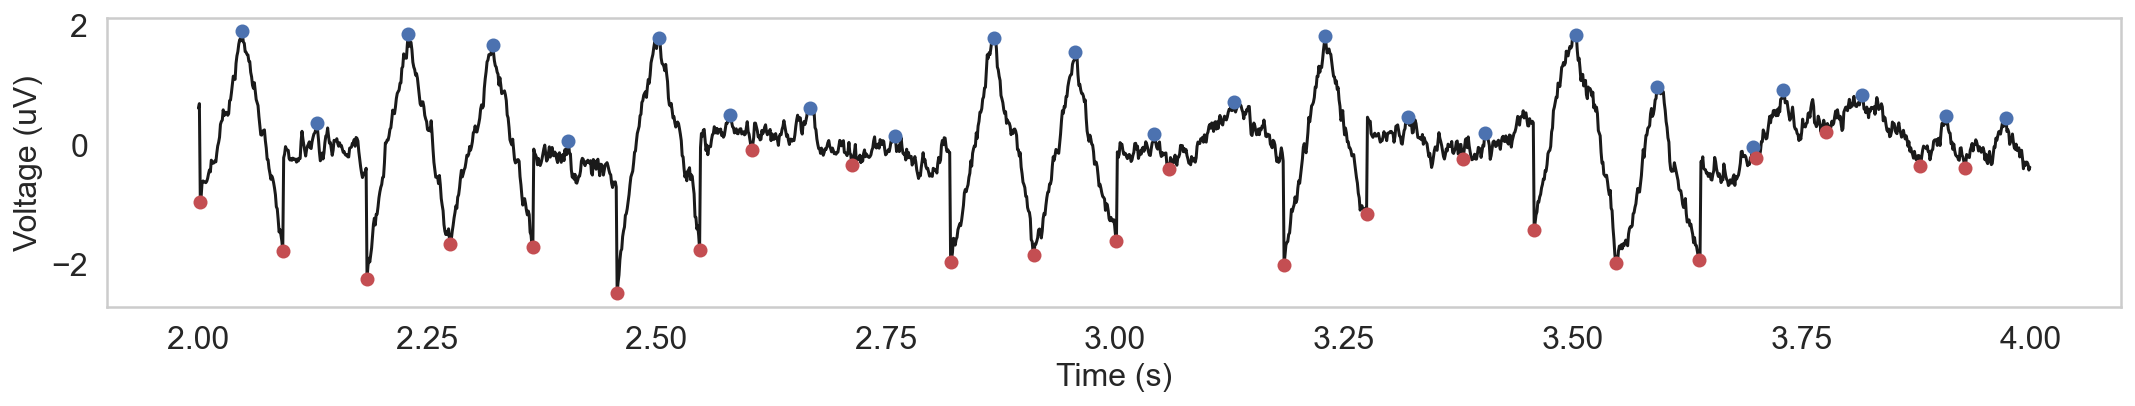

In [6]:
f_alpha = (6,14) # broader alpha range for peak / trough identification
sig_narrow = filt.filter_signal(bursty_data, fs, 'bandpass', f_alpha, remove_edges=False)

# find rising and falling zerocrossings from narrowband filtered data
rise_xs = find_flank_zerox(sig_narrow, 'rise')
decay_xs = find_flank_zerox(sig_narrow, 'decay')

# find peaks and troughs (this function also does the above)
peaks, troughs = find_extrema(bursty_data, fs, f_alpha,
                              filter_kwargs={'n_seconds':nsec})

plot_cyclepoints_array(bursty_data, fs, peaks=peaks, troughs=troughs, xlim=(2, 4))

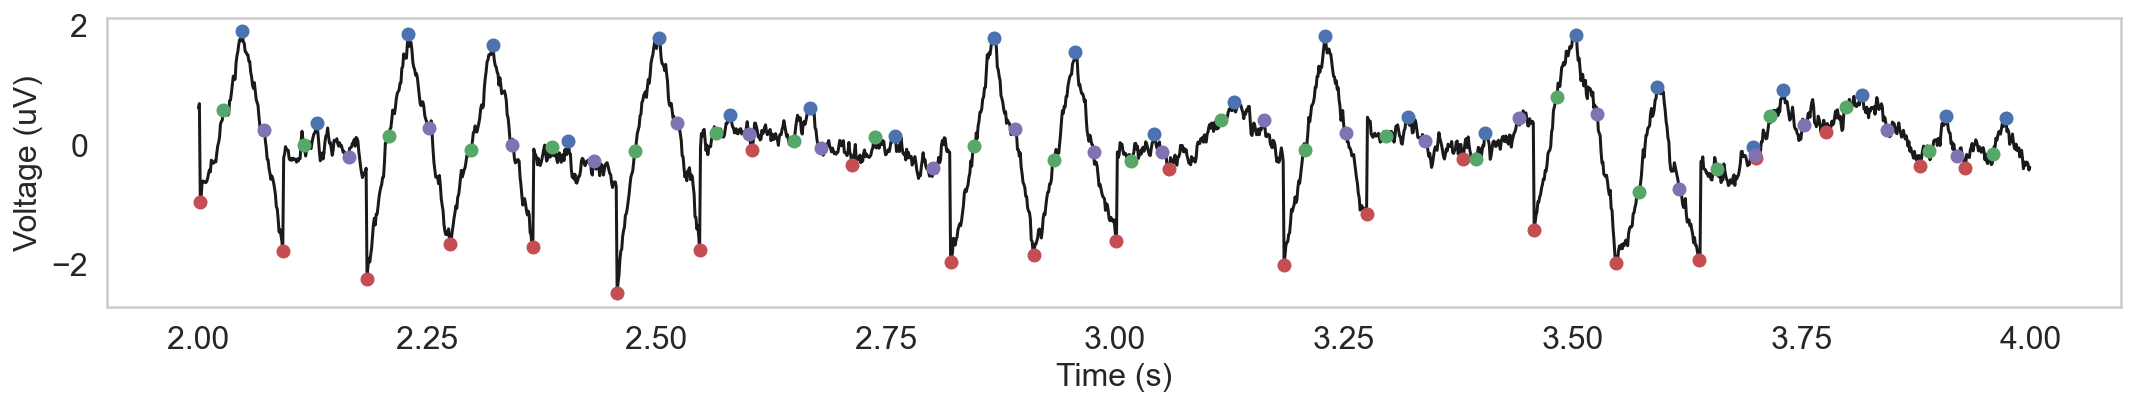

In [7]:
# find rise and fall midpoints between zerocrossings
rises, decays = find_zerox(sig_narrow, peaks, troughs)

plot_cyclepoints_array(bursty_data, fs, xlim=(2, 4), peaks=peaks, troughs=troughs,
                       rises=rises, decays=decays)

#### We can then use bycycle to parameterize each cycle!
##### The major trick here is to work with the `threshold_kwargs` to see how those affect the outputs.

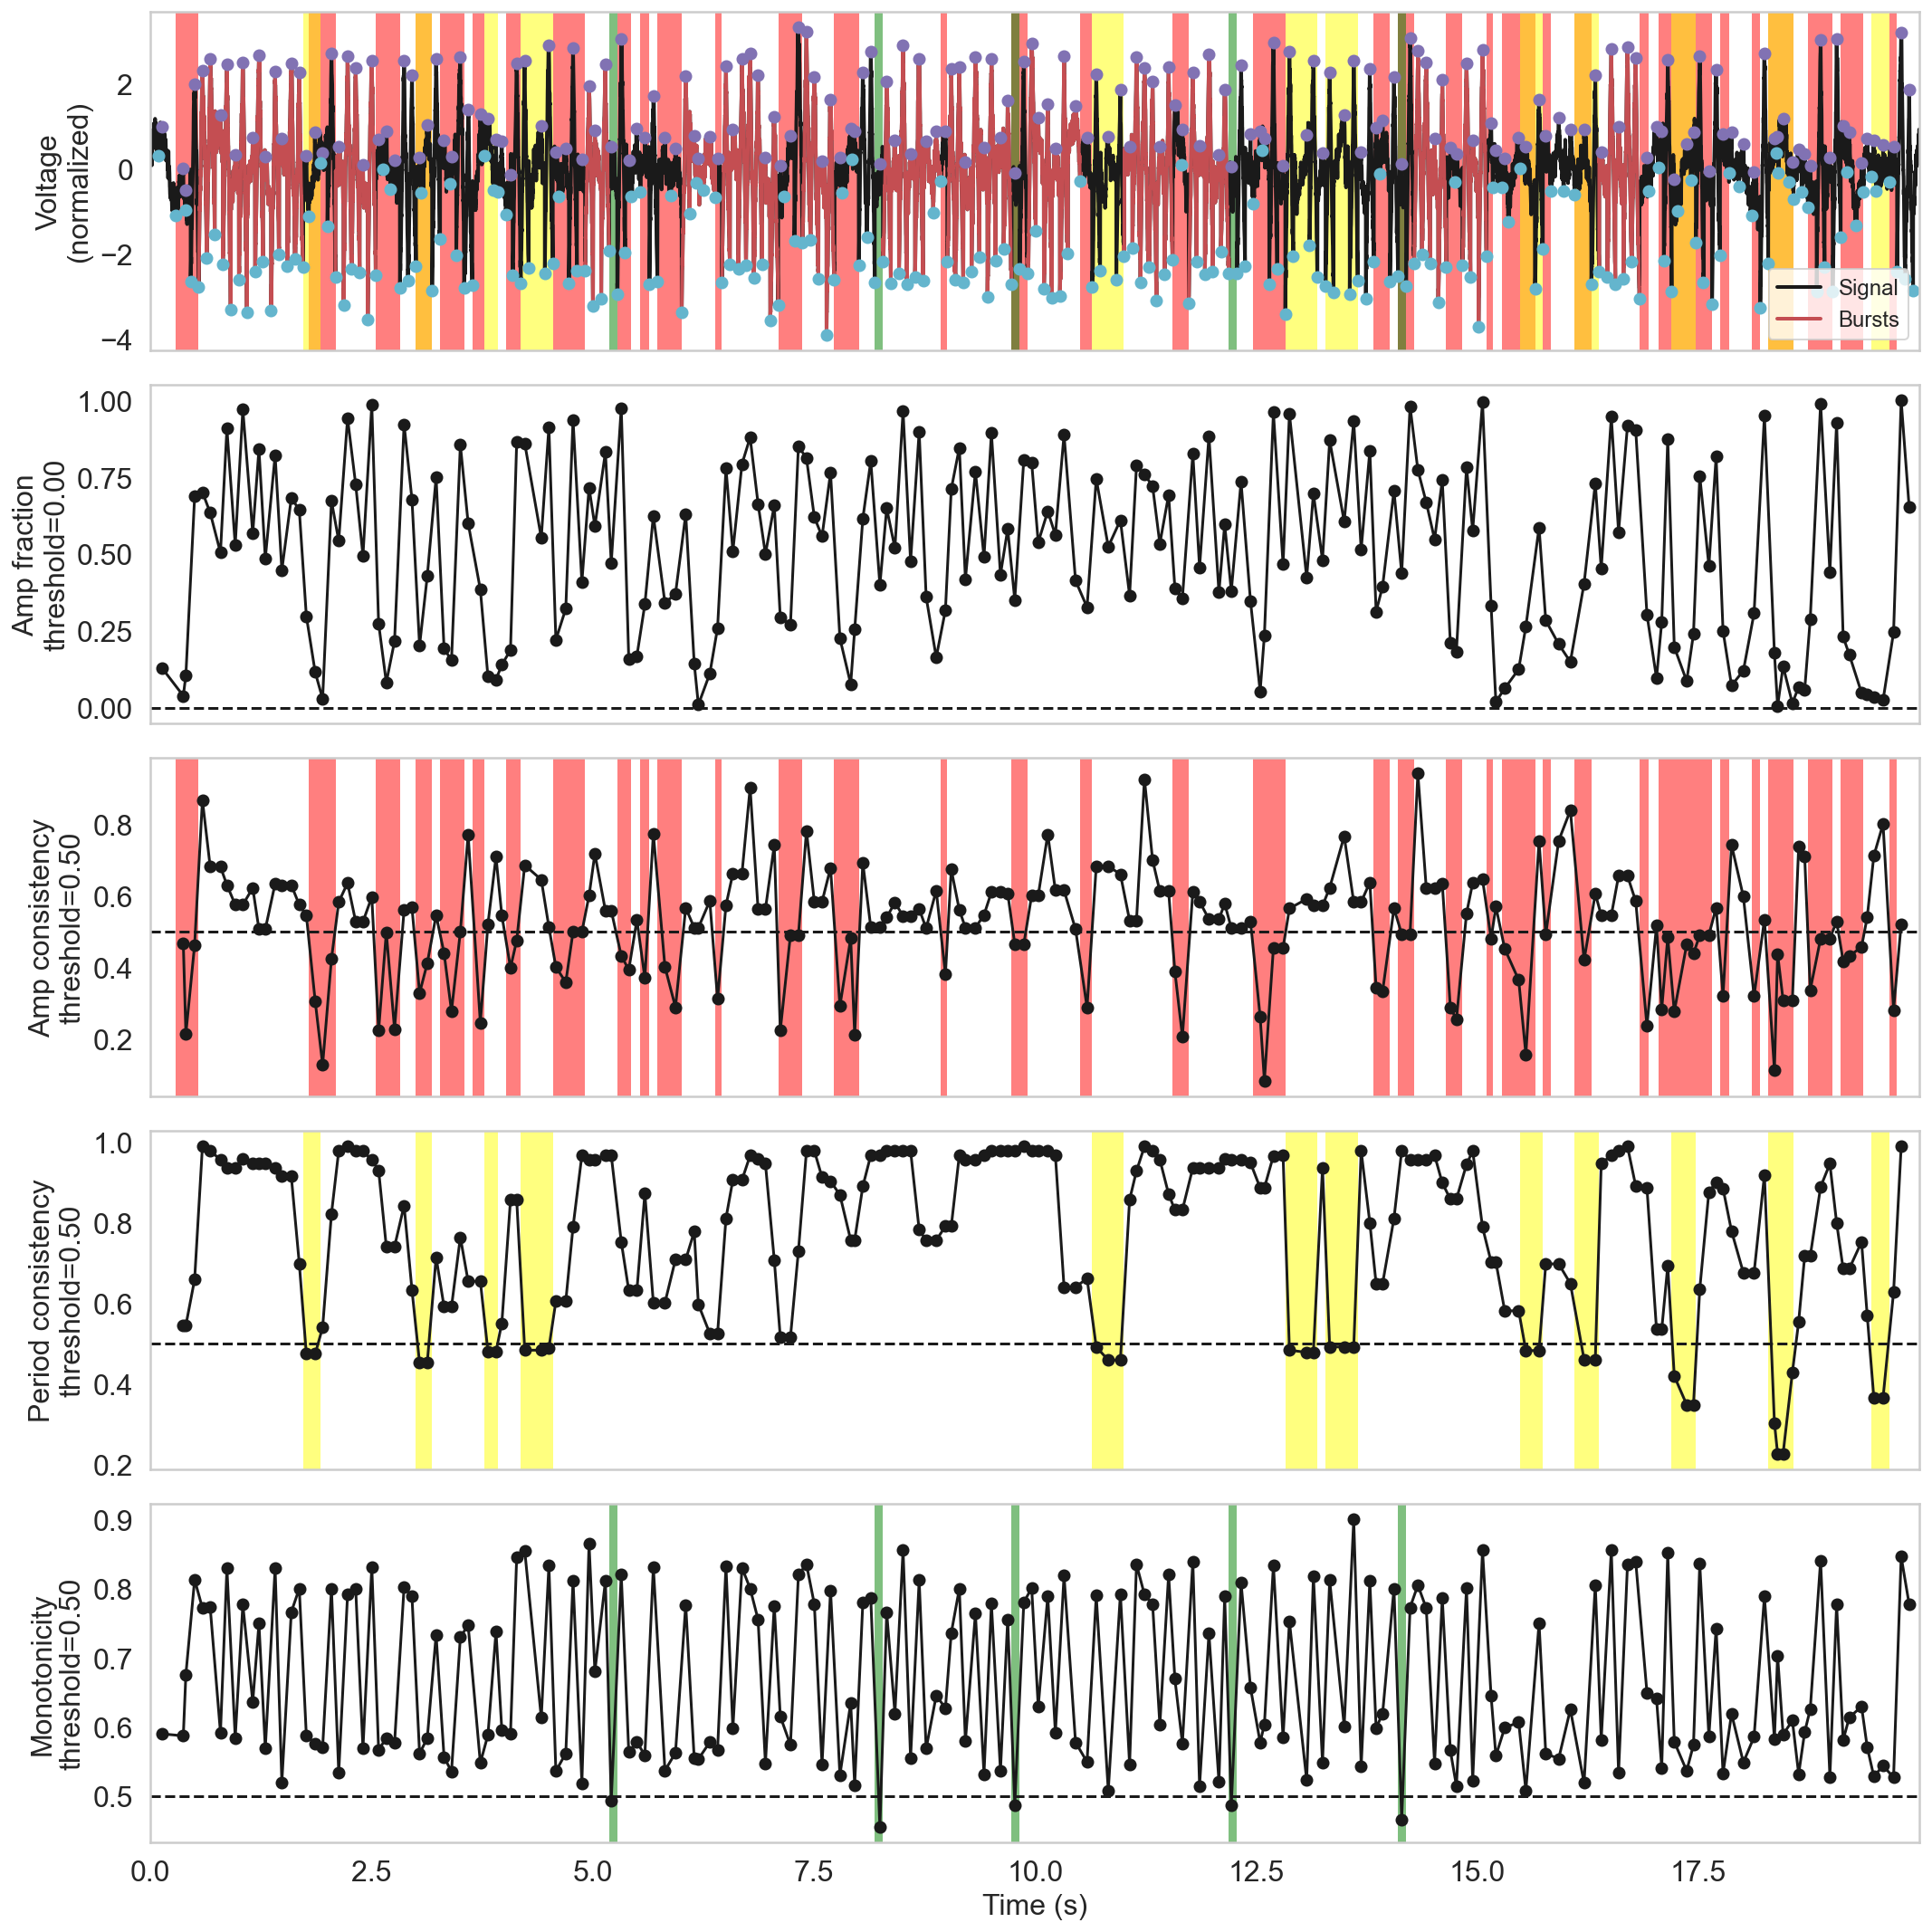

In [9]:
threshold_kwargs = {'amp_fraction_threshold': 0., 'amp_consistency_threshold': .5,
                    'period_consistency_threshold': .5, 'monotonicity_threshold': .5}

df_features = compute_features(bursty_data, fs, f_alpha, threshold_kwargs=threshold_kwargs)
df_features

plot_burst_detect_summary(df_features, bursty_data, fs, threshold_kwargs=threshold_kwargs)
